# Model Training for Pneumonia Detection


We will **build** and **train** three models, Multi Layer Perceptron (MLP); Convolutional Neural Network (CNN) and Data-efficient Image Transformer (DeIT), for binary classification to predict if a patient is diagnosed with Pneumonia negative (0) or is Normal positive (1) (we used inverse convention).

## 🛠️ Supported Hardware

This notebook can run in a CPU or in a GPU.

✅ AMD Instinct™ Accelerators  
✅ AMD Radeon™ RX/PRO Graphics Cards  
✅ AMD EPYC™ Processors  
✅ AMD Ryzen™ (AI) Processors  

Suggested hardware: **AI PC powered by AMD Ryzen™ AI Processors**

## ⚡ Recommended Software Environment

::::{tab-set}

:::{tab-item} Linux
- [Install Docker container](https://amdresearch.github.io/aup-ai-tutorials//env/env-gpu.html)
- [Install PyTorch](https://amdresearch.github.io/aup-ai-tutorials//env/env-cpu.html)
:::

:::{tab-item} Windows
- [Install Direct-ML](https://amdresearch.github.io/aup-ai-tutorials//env/env-gpu-windows.html)
- [Install PyTorch](https://amdresearch.github.io/aup-ai-tutorials//env/env-cpu.html)
:::
::::

## 🎯 Goals

- Predict whether or not an X-ray shows signs of pneumonia
- Prepare dataset, do data augmentation, create Python Dataloader
- Build and train a Multi Layer Perceptron model using PyTorch
- Build and train a Convolutional Neural Network model using PyTorch
- Fine-tune a Data-efficient Image Transformer using PyTorch

## Import the necessary libraries

In [1]:
import cv2
import os
import numpy as np
import torch
import time

import matplotlib.pyplot as plt

## Download Dataset

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

```{note}
You will need an account in [Kaggle](https://www.kaggle.com/), you can add your Kaggle API key to `~/.kaggle/kaggle.json`.

Or download the dataset from here ([download link](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)) and unzip it inside the `datasets` folder.
The unzipped 'chest_xray' folder and a folder which includes this notebook should be at the same level for relative directory paths to work as is.
```

```{warning}
double check what happens when unzipping file manually
```

In [2]:
if not os.path.isdir('datasets/chest_xray/chest_xray'):
    import kaggle
    print('Downloading dataset')
    kaggle.api.dataset_download_files('paultimothymooney/chest-xray-pneumonia', path='datasets', unzip=True)

## Visualize Sample X-Rays

Let's get some images from the dataset and display them

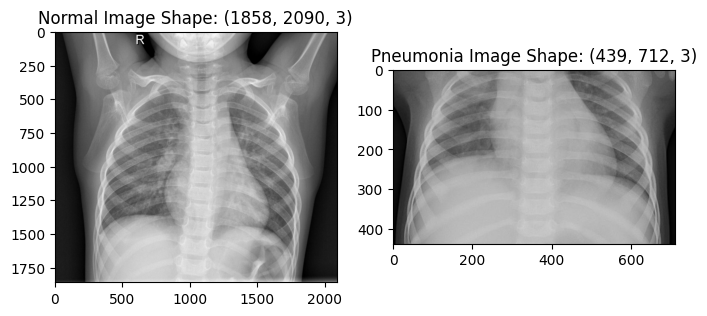

In [3]:
train_data_path = 'datasets/chest_xray/chest_xray/train/'

nimg = cv2.imread(train_data_path + 'NORMAL/IM-0115-0001.jpeg')
pimg = cv2.imread(train_data_path + 'PNEUMONIA/person1_bacteria_1.jpeg')

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(nimg)
plt.title(f"Normal Image Shape: {nimg.shape}")

plt.subplot(1,2,2)
plt.imshow(pimg)
plt.title(f"Pneumonia Image Shape: {pimg.shape}")
plt.show()

## Resize images

Let's resize the images to a shape of 112x112 in preparation for CNN input layer

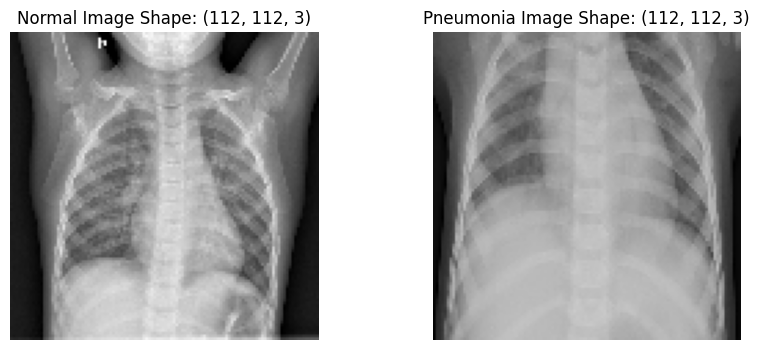

In [4]:
nimage = cv2.resize(nimg, (112,112))
pimage = cv2.resize(pimg, (112,112))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(nimage)
plt.title(f"Normal Image Shape: {nimage.shape}")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(pimage)
plt.title(f"Pneumonia Image Shape: {pimage.shape}")
plt.axis('off')
plt.show()

## Augment the dataset using transforms

Using a different transformation of the original image in each epoch 

i.e. Total number of images does not change after Augmentation

This is meant to reduce bias and bring fairness, so as to accommodate images that might not have been perfectly straight, imperfect zoom, incorrect brightness setting etc

```{warning}
Improve description
```

In [5]:
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(0.5),        # Horizontal flip (set to False if not needed)
    transforms.RandomAffine(degrees=30,             # No additional rotation, but apply width/height shift and shear
                            shear=20,              # Shear range
                            interpolation=InterpolationMode.BILINEAR,
                            scale=(0.9, 1.2)),     # Zoom range
    transforms.ToTensor(),                          # Convert image to Tensor
])

nimage_tensor = torch.tensor(nimage, dtype=torch.float32).permute(2, 0, 1)  # Convert to CxHxW format

Apply transformation to one image and see the result of ten calls to the `transform` function we described. 

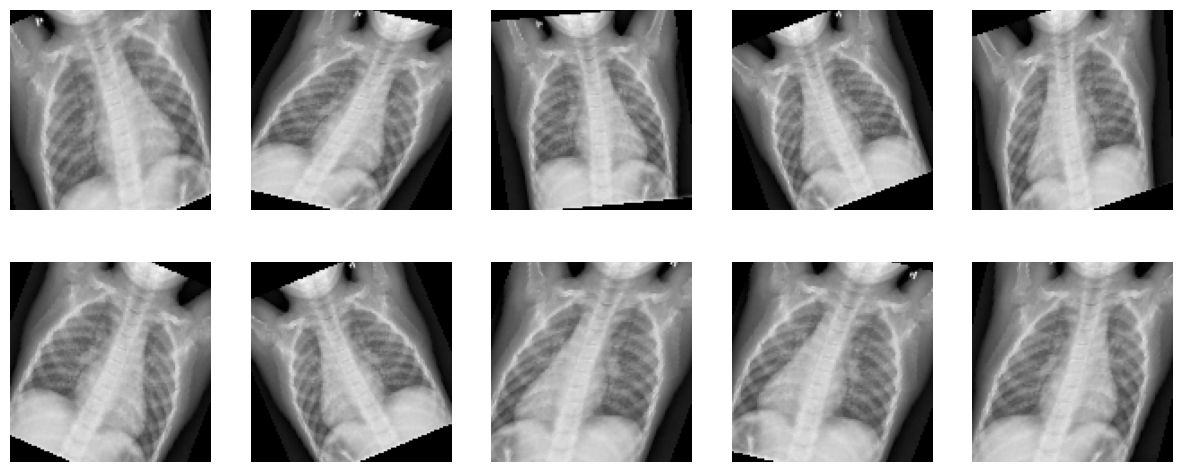

In [6]:
plt.figure(figsize=(15,6))

for i in range(10):
    image = transform(nimage)
    plt.subplot(2,5,i+1)
    img = image.cpu().detach().numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(img)

## Prepare the datasets

Load train, validate and test datasets.

In [7]:
dataset_path = 'datasets/chest_xray/chest_xray/'
val_data_normal = f'{dataset_path}val/NORMAL'
val_data_pmonia = f'{dataset_path}val/PNEUMONIA'
test_data_normal = f'{dataset_path}test/NORMAL'
test_data_pmonia = f'{dataset_path}test/PNEUMONIA'
train_data_normal = f'{dataset_path}train/NORMAL'
train_data_pmonia = f'{dataset_path}train/PNEUMONIA'

def get_data(data_folder, xtype):
    xlist=[]
    ylist=[]
    images = 0
    for i, j, files in os.walk(data_folder):
        for k in files:
            img_path = (os.getcwd()+f'/{data_folder}/{k}')
            if img_path.endswith('.jpeg'):
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img_array = cv2.resize(img, (112, 112))
                xlist.append(img_array)
                ylist.append('1' if xtype=='normal' else '0') # Assign Positive(1) to Normal images and Assign Negative(0) to Pneumonia images

    return np.array(xlist), np.array(ylist).astype('uint8')

In [8]:
x_trainn, y_trainn = get_data(train_data_normal, 'normal')
x_trainp, y_trainp = get_data(train_data_pmonia, 'pneumonia')

x_valn, y_valn = get_data(val_data_normal, 'normal')
x_valp, y_valp = get_data(val_data_pmonia, 'pneumonia')

x_testn, y_testn = get_data(test_data_normal, 'normal')
x_testp, y_testp = get_data(test_data_pmonia, 'pneumonia')

Let's plot the total images by lung condition and by dataset split

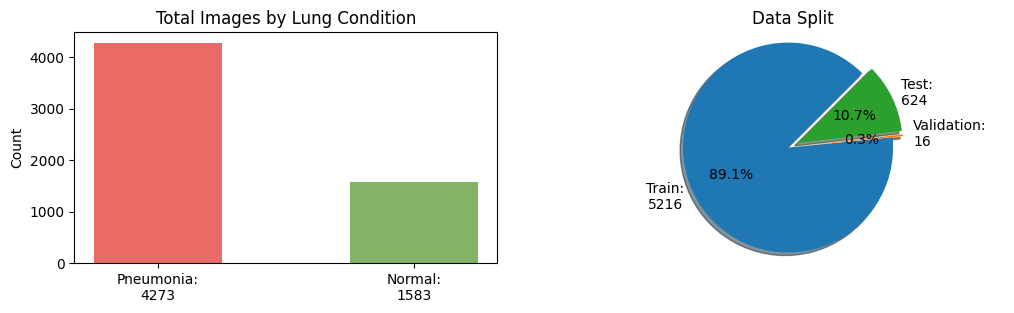

In [9]:
conditions_count = [len(x_trainp) +  len(x_valp) + len(x_testp), len(x_trainn) + len(x_valn) + len(x_testn)]
labels = [f'Pneumonia:\n{conditions_count[0]}', f'Normal:\n{conditions_count[1]}']
dataset_samples = [len(x_trainn) + len(x_trainp), len(x_valn) + len(x_valp), len(x_testn) + len(x_testp)]
dataset_labels = [f'Train:\n{dataset_samples[0]}', f'Validation:\n{dataset_samples[1]}', f'Test:\n{dataset_samples[2]}']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

ax1.bar(labels, conditions_count, width=0.5, align='center', color=['#EA6B66', '#82B366'])
ax1.set_title("Total Images by Lung Condition")
ax1.set_ylabel("Count")

ax2.pie(dataset_samples, explode=(0.0, 0.1, 0.1), labels=dataset_labels, autopct='%1.1f%%', textprops={'size': 'medium'}, shadow=True,
        startangle=45, colors=['#1F77B4', '#FF7F0E', '#2CA02C'])
ax2.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle
ax2.title.set_text('Data Split')

plt.show()

As observed in the plots above, the dataset split is imbalanced towards the train split and pneumonia condition.

In the next cell, we will create a more balanced dataset split with an equal number of images per condition. We will end up with a dataset split with the follow distribution 80% for train, 10% for validation and 10% for test.

As Pneumonia images are much larger number than normal, 1073 Pneumonia images are sampled to match 1073 normal images and treat the label imbalance which are left after setting 20% for validation aside.

In [10]:
x_train = np.append(x_trainn[:1073], x_trainp[:1073], 0)
y_train = np.append(y_trainn[:1073], y_trainp[:1073], 0)

x_train = x_train/255

x_val_1 = np.append(x_valn, x_valp, 0)
y_val_1 = np.append(y_valn, y_valp, 0)

# Adding 20% of train images into validation set
x_val_2 = np.append(x_val_1, x_trainp[1073:1341], 0)
y_val_2 = np.append(y_val_1, y_trainp[1073:1341],  0)
x_val = np.append(x_val_2, x_trainn[1073:1341], 0)
y_val = np.append(y_val_2, y_trainn[1073:1341],  0)

x_val=x_val/255

x_test = np.append(x_testn, x_testp, 0)
y_test = np.append(y_testn, y_testp, 0)

x_test=x_test/255

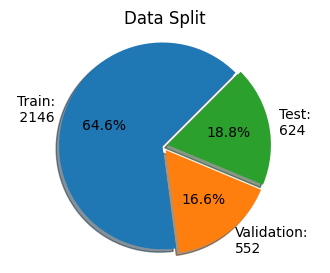

In [11]:
dataset_split = [len(x_train), len(x_val), len(x_test)]
labels = f'Train:\n {dataset_split[0]}',f'Validation:\n{dataset_split[1]}', f'Test:\n{dataset_split[2]}'
explode = (0, 0.05, 0.05)  # only "explode" the 'test data' slice

fig1, ax1 = plt.subplots(figsize=(4, 3))  # Adjust the size (width, height) as needed
ax1.pie(dataset_split, explode=explode, labels=labels, autopct='%1.1f%%', textprops={'size': 'medium'}, shadow=True,
        startangle=45, colors=['#1F77B4', '#FF7F0E', '#2CA02C'])
ax1.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle
ax1.title.set_text('Data Split')

plt.show()

Select device where do we want to run the training.

```{tip}
If you have both a CPU and a GPU, you can force to use one of them by setting device.

```python
device = torch.device("cpu")
```
```

In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Device: {device} {torch.cuda.get_device_name() if device == torch.device("cuda") else ""}')

Device: cuda AMD Instinct MI210


Create PyTorch `TensorDataset` and `Dataloader` objects for training. The dataset will live either on CPU and GPU depending on the `device` variable.

In [13]:
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors and move to device (GPU if available)
x_train_t = torch.from_numpy(x_train).float().to(device)
y_train_t = torch.from_numpy(y_train).float().to(device)

x_val_t = torch.from_numpy(x_val).float().to(device)
y_val_t = torch.from_numpy(y_val).float().to(device)

x_test_t = torch.from_numpy(x_test).float().to(device)
y_test_t = torch.from_numpy(y_test).float().to(device)

train_dataset = TensorDataset(x_train_t, y_train_t)
val_dataset = TensorDataset(x_val_t, y_val_t)
test_dataset = TensorDataset(x_test_t, y_test_t)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(f'Training images: {len(train_loader.dataset)}, Validation images: {len(val_loader.dataset)}, Test images: {len(test_loader.dataset)}')

Training images: 2146, Validation images: 552, Test images: 624


Define a function to return the label in a string format

In [14]:
def full_label(n):
    return "Normal" if n == 1 or n == "1" else "Pneumonia"

## Multi-Layer Perceptron Model

### Define the MLP Model

Objective is to build and train a model to classify x-ray images as either `Pneumonia` or `Normal`

The architecture of our NN model is as follows:

- the model receives input images of size 112 x 112 x 1
- the input data goes through a flattening layer
- the flatten input goes through three connected layers, 
- the drop out layer is used to decrease computation time (less parameters) and adjust overfitting

For the dropout layer, set the probability of dropping input units during training to 0.3.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MLPPneumonia(nn.Module):
    def __init__(self):
        super(MLPPneumonia, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(112 * 112, 12544)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(12544, 3136)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(3136, 784)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc4 = nn.Linear(784, 1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

model_fc = MLPPneumonia()
model_fc

MLPPneumonia(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=12544, out_features=12544, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=12544, out_features=3136, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=3136, out_features=784, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=784, out_features=1, bias=True)
)

Run inference with a random tensor to verify that the model is correctly defined.

In [16]:
random_input = torch.randn(1, 1, 112, 112)
with torch.no_grad():
    print(model_fc(random_input))

tensor([[-0.0158]])


### Train the MLP Model

Let's start by setting a random seed to get reproducible results.

In [17]:
torch.manual_seed(1234)
np.random.seed(1234)

Initialize the weights and bias to a known value. We do this to be able to compare how different hyperparameters affect the accuracy of our model.

In [18]:
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    elif isinstance(m, torch.nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            m.bias.data.fill_(0.01)

In [19]:
model_fc.apply(init_weights)

MLPPneumonia(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=12544, out_features=12544, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=12544, out_features=3136, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=3136, out_features=784, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=784, out_features=1, bias=True)
)

### Define the Training Loop

We are going to define a training loop that can help us training the MLP as well as with the CNN model.

We will track train and validation loss, and train and validation accuracy.

The training loop iterates over the number of specified epochs.

First, we put the model in training mode to track the gradients in the backward pass, then we iterate over the `train_loader`. Image augmentation is applied with the `tranform` function, we do this to make the model more general. We run the forward pass with a batch of transformed images, with the output of this pass we compute the loss based on the `loss_fn`. After this, we reset the optimizer and run a backward pass and finally apply the optimization (update weights). We keep track of the accuracy and loss so we can display it later.

Secondly, we put the model into evaluation mode, no track of gradients. We iterate over the `val_loader`, this time we do not apply the transformation as we want to see how the model performs with the unmodified validation dataset. We then compute the loss and track it. Note that this time, we do not apply the optimization.

Finally, we print the training and validation loss and accuracy. To conclude, we return the lists with the history of the training progress.

In [ ]:
def train_loop(model, loss_fn, optimizer, device, epochs=30, print_every=5):
    train_loss_list, val_loss_list, val_accuracy_list, train_accuracy_list = [], [], [], []

    model.to(device) # move the model to GPU if available

    for epoch in range(epochs):
        training_loss, correct, total = 0, 0, 0
        model.train()
        for inputs, targets in train_loader:
            # Forward pass
            transformed_batch = torch.stack([transform(image) for image in inputs]).squeeze(1) # apply data augmentation
            outputs = model(transformed_batch.to(device).unsqueeze(1))
            loss = loss_fn(outputs, targets.unsqueeze(1))
            training_loss += loss.item()
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # track accuracy
            predicted = torch.where(outputs.squeeze(1) < 0.5, torch.tensor(0), torch.tensor(1))
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        training_loss /= len(train_loader)
        train_accuracy = 100 * correct / total

        correct, total = 0, 0
        # Validation
        model.eval()
        with torch.no_grad():  # No need to track gradients
            val_loss = 0
            for inputs, targets in val_loader:
                outputs = model(inputs.to(device).unsqueeze(1))
                loss = loss_fn(outputs, targets.unsqueeze(1))
                val_loss += loss.item()

                # track accuracy
                predicted = torch.where(outputs.squeeze(1) < 0.5, torch.tensor(0), torch.tensor(1))
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
            val_loss /= len(val_loader)
            val_accuracy = 100 * correct / total

        if epoch % print_every == 0 or epoch == epochs - 1:
            print(f'Epoch {epoch+1:4d}/{epochs}, training loss: {training_loss:3.12f}, '
                  f'validation loss: {val_loss:3.12f} training accuracy: {train_accuracy:.2f}, validation accuracy {val_accuracy:.2f}')
        val_loss_list.append(val_loss)
        train_loss_list.append(training_loss)
        train_accuracy_list.append(train_accuracy)
        val_accuracy_list.append(val_accuracy)

    return model, train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list

Now that we have a generic training loop, let us set the type of optimizer and loss function.

[Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) is used as it is the most popular gradient-based optimization algorithm.
The loss (cost) function suitable for binary classification model is [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html), we use this loss function because the last layer does not apply sigmoid.

In [21]:
import torch.optim as optim
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_fc.parameters())

Let's train the model for 30 epochs on the train set and validate on the validation set. The performance depends on the initial hyperparameters such as learning rate and choice of optimizer. We collect model accuracy on the training and validation datasets. as described in the training loop.

In [22]:
t_start = time.time()
model_fc, train_loss_list, validation_loss_list, train_accuracy_list, validation_accuracy_list = train_loop(model_fc, loss_fn, optimizer, device)
ttrain_fc = time.time() - t_start
print(f'It took {ttrain_fc:.2f}s to train the FC model')

Epoch    1/30, training loss: 5.024055624271, validation loss: 0.580416288641 training accuracy: 54.43, validation accuracy 54.53
Epoch    6/30, training loss: 0.412257264204, validation loss: 0.506033963524 training accuracy: 80.75, validation accuracy 82.43
Epoch   11/30, training loss: 0.401754696799, validation loss: 0.375333455702 training accuracy: 82.53, validation accuracy 84.78
Epoch   16/30, training loss: 0.314998313127, validation loss: 0.362573448569 training accuracy: 86.11, validation accuracy 85.87
Epoch   21/30, training loss: 0.316793347983, validation loss: 0.304066286319 training accuracy: 86.21, validation accuracy 85.51
Epoch   26/30, training loss: 0.348656713305, validation loss: 0.421367014448 training accuracy: 85.60, validation accuracy 78.99
Epoch   30/30, training loss: 0.289570106851, validation loss: 0.372500422928 training accuracy: 87.47, validation accuracy 84.60
It took 76.70s to train the FC model


Next let's define a function that can plot the loss and accuracy for training and validation sets

### Define Training Loop Plots

In [23]:
def train_loop_plots(train_loss_list, validation_loss_list, train_accuracy_list, validation_accuracy_list):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(validation_loss_list, '-o', label='Validation Loss')
    ax.plot(train_loss_list, '-x', label='Train Loss')
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Loss Progress")
    ax.legend(loc="upper right")

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(train_accuracy_list, '-o', label='Train accuracy')
    ax.plot(validation_accuracy_list, '-x', label='Validation accuracy')
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Accuracy Progress")
    ax.legend(loc="lower right")
    #ax.set_ylim(50,100)
    
    plt.show()

Let's plot the loss and accuracy progression

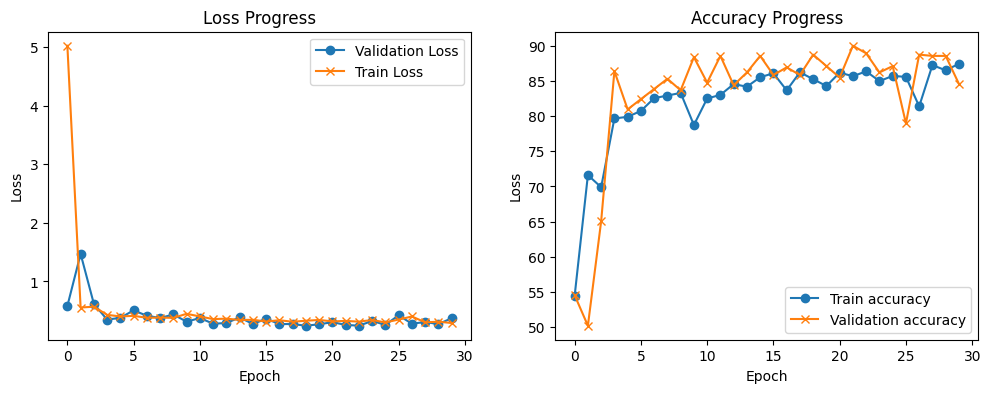

In [24]:
train_loop_plots(train_loss_list, validation_loss_list, train_accuracy_list, validation_accuracy_list)

As you can see, after 5 epochs the training achieves a low training loss and validation loss. As the two of them follow the same trend, the model is still learning at a lower rate. WE can see that with the accuracy plot, the training accuracy trend is slowly improving, and the validation accuracy is starts to swing after 5 epochs, although, it follow the general trend of the train accuracy,

### MLP Evaluation

The test data is now used to evaluate the performance (accuracy) of our MLP model on unseen data. Note that accuracy is the default metric if one trains the model with the accuracy metric in mind.

Let's compute the inference for the full test dataset at once and display the result of one example.

In [ ]:
with torch.no_grad():
    outputs = model_fc(x_test_t).squeeze()
    y_test_pred_mlp = (torch.sigmoid(outputs) > 0.5).float()

print(f"Predicted label: {y_test_pred_mlp[0]}. Ground truth label: {y_test_t[0]}")

Predicted label: 1.0. Ground truth label: 1.0


Calculate correct and misclassifications

In [26]:
test_misclass_mlp = (y_test_t != y_test_pred_mlp).sum().item()
test_goodclass_mlp = (y_test_t == y_test_pred_mlp).sum().item()
mlp_test_acc = (test_goodclass_mlp/len(y_test_pred_mlp))*100
print(f'Test, Correct classified examples: {test_goodclass_mlp}. Misclassified examples: {test_misclass_mlp}')
print(f'Test, prediction accuracy: {mlp_test_acc:.2f}%')

Test, Correct classified examples: 493. Misclassified examples: 131
Test, prediction accuracy: 79.01%


Display the confusion matrix. The sum of the elements in the main diagonal should be the same as the correct classifications we got above. The sum of the elements on the off-diagonal should be the same as the misclassifications above.

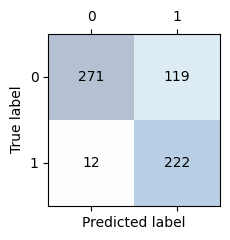

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score

conf_matrix_mlp = confusion_matrix(y_test_t.cpu(), y_test_pred_mlp.cpu())

def confusion_matrix_plot(conf_matrix):
    _, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

confusion_matrix_plot(conf_matrix_mlp)

Get model metrics, F1, precision and recall

In [28]:
f1_mlp = f1_score(y_test_t.cpu(), y_test_pred_mlp.cpu())
precision_mlp = precision_score(y_test_t.cpu(), y_test_pred_mlp.cpu())
recall_mlp = recall_score(y_test_t.cpu(), y_test_pred_mlp.cpu())

print(f'Precision score: {precision_mlp:.2f}\nRecall score:    {recall_mlp:0.2f}\nf1 score:        {f1_mlp:.2f}')

Precision score: 0.65
Recall score:    0.95
f1 score:        0.77


### Show what the MLP model is learning after each layer

In this part, we're going to try to understand what the model has learned and see how it behaves for one example.

We are going to pick one example from our test data to visualize some of the our MLP model activations after each layer. Below we print the original image.

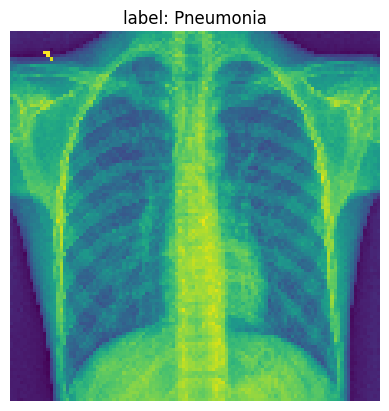

In [29]:
img_idx= 14

test_img_tensor = x_test_t[img_idx].unsqueeze(0).cpu()
  
plt.imshow(test_img_tensor[0]);
plt.title(f'label: {full_label(str(y_test_t[img_idx]))}')
plt.axis('off')
plt.show()

Let's create hooks to the four linear layers so we can observe the activation values

```{note}
`register_forward_hook` allows us to peak at the model intermediate values without having to modify the model. These hooks are executed when the `forward()` method is called. Thus, adding extra logic. If you are measuring performance, remove the hooks. Learn more about hooks [here](https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/).
```

In [30]:
activation_fc = {}
def get_activation(name):
    def hook(model_fc, input, output):
        activation_fc[name] = output.detach()
    return hook
hook_list = []
hook_list.append(model_fc.relu1.register_forward_hook(get_activation('relu1')))
hook_list.append(model_fc.relu2.register_forward_hook(get_activation('relu2')))
hook_list.append(model_fc.relu3.register_forward_hook(get_activation('relu3')))
hook_list.append(model_fc.dropout.register_forward_hook(get_activation('dropout')))
hook_list.append(model_fc.fc4.register_forward_hook(get_activation('fc4')))

with torch.no_grad():
    y_test_pred_idx = model_fc(x_test_t[img_idx].unsqueeze(0))

In [31]:
import pandas as pd

# original example
print('Feature values original example:')
pd.DataFrame((x_test_t[img_idx].squeeze(1).cpu().numpy())).head(3)

Feature values original example:


,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
0,0.145098,0.149020,0.133333,0.129412,0.137255,0.137255,0.121569,0.129412,0.137255,0.137255,...,0.101961,0.121569,0.129412,0.117647,0.109804,0.109804,0.121569,0.109804,0.121569,0.125490
1,0.149020,0.149020,0.141176,0.133333,0.133333,0.145098,0.125490,0.121569,0.125490,0.129412,...,0.121569,0.101961,0.113725,0.113725,0.109804,0.117647,0.109804,0.109804,0.101961,0.117647
2,0.137255,0.141176,0.133333,0.125490,0.125490,0.129412,0.125490,0.125490,0.117647,0.117647,...,0.105882,0.105882,0.113725,0.117647,0.105882,0.105882,0.098039,0.109804,0.117647,0.125490


In [32]:
print('Learned activations first layer:')
pd.DataFrame(activation_fc['relu1'].reshape(112, 112).cpu()).head(3)

Learned activations first layer:


,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
print('Learned activations second layer:')
pd.DataFrame(activation_fc['relu2'].reshape(56, 56).cpu()).head(3)

Learned activations second layer:


,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,0.0,0.0,0.0,0.00000,0.0,0.0,1.85383,0.0,0.0,0.000000,...,0.622014,0.0,0.0,2.872196,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.66006,0.0,0.0,0.00000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2.177356,0.0
2,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.952339,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


In [34]:
print('Learned activations third layer:')
pd.DataFrame(activation_fc['relu3'].reshape(28, 28).cpu()).head(3)

Learned activations third layer:


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.160825,0.0,0.682715,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.542695,0.0,0.000000,0.0,0.0,0.0,0.0


In [35]:
print('Learned activations dropout layer:')
pd.DataFrame(activation_fc['dropout'].reshape(28, 28).cpu()).head(3)

Learned activations dropout layer:


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.160825,0.0,0.682715,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.542695,0.0,0.000000,0.0,0.0,0.0,0.0


In [36]:
print('Learned activations forth layer:')
pd.DataFrame(activation_fc['fc4'].reshape(1).cpu()).head(3)

Learned activations forth layer:


,0
0,2.98974


Now, let's plot the activations after different layers. We create a list where we start with the original image and then we append the output feature maps of different layers.

In [37]:
activation_fc_list = [x_test_t[0].reshape(112*112).unsqueeze(0).cpu()]
for idx, v in activation_fc.items():
    activation_fc_list.append(v.cpu())

Next, we plot the values so you can visualize what is happening.

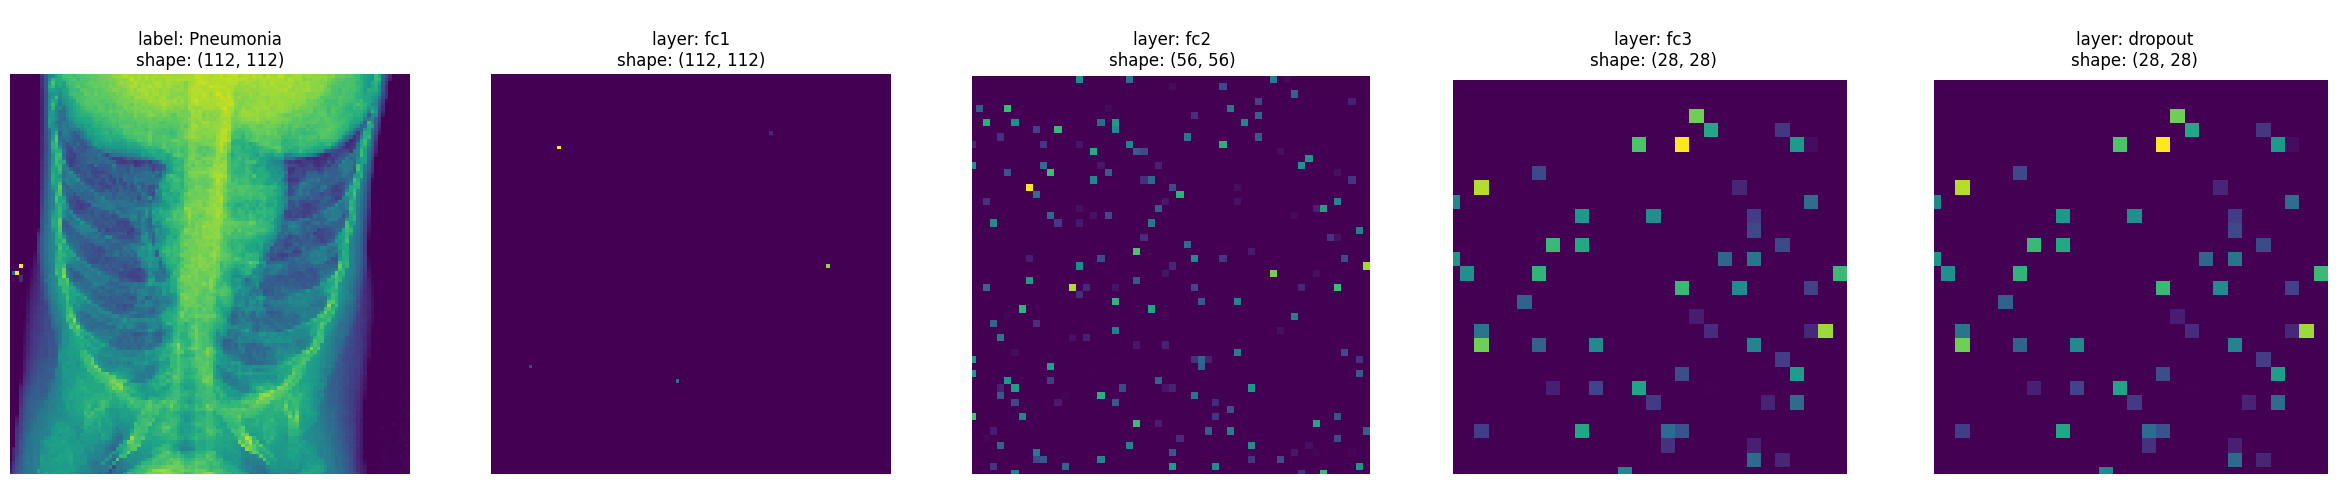

In [38]:
fig, axes = plt.subplots(1, 5, sharey=False, figsize=(30, 10))
                                                    
for idx, ax in enumerate(axes.flatten()):
    # save activation and shape
    activation = activation_fc_list[idx]
    shape = int(np.sqrt(activation.shape)[1]), int(np.sqrt(activation.shape)[1])
    
    # plot activation
    ax.imshow(activation.reshape(shape))
    ax.set_xlim(0, shape[0])
    ax.set_ylim(0, shape[0])
    if idx==0:
        ax.set_title(f'label: {full_label(str(y_test_t[img_idx]))}\nshape: {shape}')
    elif idx==4:
        ax.set_title(f'\nlayer: dropout\nshape: {shape}')
    else:
        ax.set_title(f'\nlayer: fc{idx}\nshape: {shape}')
    ax.axis('off')
plt.show()

From the images, you can see that some of the initial layers are quite sparse. Let's compute the ratio of elements close to 0, with tolerance $1^{-6}$

In [39]:
for idx, activations in enumerate(activation_fc_list):
    if idx == 0 or idx > len(activation_fc_list)-3:
        continue
    close_to_zero_count = torch.sum(torch.abs(activations) < 1e-6).item()
    print(f'Layer fc{idx} sparcity: {(close_to_zero_count / activations.numel())*100:.2f}%')

Layer fc1 sparcity: 99.95%
Layer fc2 sparcity: 94.13%
Layer fc3 sparcity: 92.73%


```{tip}
Remove the hooks by iterating over the list and calling `.remove()`
```

```python
for hook in hook_list:
    hook.remove()
```

## Convolutional Neural Network Model

We are now going to define a CNN model that we will use to classify between healthy patients and patients with pneumonia.

The architecture of our CNN model is as follows

- the model receives input images of size 112 x 112 x 1 (the images have 1 grayscale channel)
- the input data goes through 4 convolutional layers that have kernels of size 3 x 3
- the first convolution has 32 output feature maps, the second one has 64, the third has 128 and the fourth has 256
- each convolution layer is followed by a max-pooling layer (this will reduce the size of the feature maps)
- the last two layers of the model are fully connected with a dropout layer in between

For each convolution strides=(1,1) is used to preserve the dimension of the inputs in the resulting feature maps. For the pooling layers, we set strides=(2,2) to subsample the image and shrink the size of the output feature maps. For the dropout layer, probability of dropping input units during training is set to 0.3.

In [40]:
import copy

class CNNPneumonia(nn.Module):
    def __init__(self):
        super(CNNPneumonia, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool2 = copy.deepcopy(self.pool1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool3 = copy.deepcopy(self.pool1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool4 = copy.deepcopy(self.pool1)
        self.fc1 = nn.Linear(256 * 7 * 7, 256)  # Adjust the input size based on the output of the last pooling layer
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 7 * 7)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

# Create the model and print the summary
model_cnn = CNNPneumonia()
print(model_cnn)

CNNPneumonia(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=256, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)


Let's run a random tensor to make sure the model is correctly defined

In [41]:
random_input = torch.randn(1, 1, 112, 112)
with torch.no_grad():
    print(model_cnn(random_input))

tensor([[0.4952]])


The next step is to train the model, decide on the type of optimizer, loss function, and metrics to compute. We will also set the random seed to a known value for reproducibility.

[Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) is used as it is the most popular gradient-based optimization algorithm. The loss (cost) function suitable for our binary classification model is [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), we selected this loss function as the output layer already includes a [sigmoid function](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html).

In [42]:
torch.manual_seed(1234)
np.random.seed(1234)

model_cnn.apply(init_weights)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-4)

We will compute model accuracy on the training, validation and test datasets.

In [43]:
t_start = time.time()
model_cnn, train_loss_list, validation_loss_list, train_accuracy_list, validation_accuracy_list = train_loop(model_cnn, loss_fn, optimizer, device, epochs=30)
ttrain_cnn = time.time() - t_start
print(f'It took {ttrain_cnn:.2f}s to train the CNN model')

Epoch    1/30, training loss: 0.757731489399, validation loss: 0.523356882234 training accuracy: 61.23, validation accuracy 68.30
Epoch    6/30, training loss: 0.267971726627, validation loss: 0.239798570259 training accuracy: 89.10, validation accuracy 90.04
Epoch   11/30, training loss: 0.236297130913, validation loss: 0.204361491319 training accuracy: 91.24, validation accuracy 92.57
Epoch   16/30, training loss: 0.189174560063, validation loss: 0.182293320385 training accuracy: 92.96, validation accuracy 92.93
Epoch   21/30, training loss: 0.164584930219, validation loss: 0.266648337711 training accuracy: 93.34, validation accuracy 90.40
Epoch   26/30, training loss: 0.179264644407, validation loss: 0.162065334152 training accuracy: 93.48, validation accuracy 94.02
Epoch   30/30, training loss: 0.144515333204, validation loss: 0.233150453973 training accuracy: 93.99, validation accuracy 92.57
It took 32.32s to train the CNN model


```{tip}

Exercise for the reader
- Try with different values for  `lr`, bigger or smaller. What happens?
- Try with a different `loss_fn` for instance, `nn.BCEWithLogitsLoss()`. What happens?

```

Display the training statistics

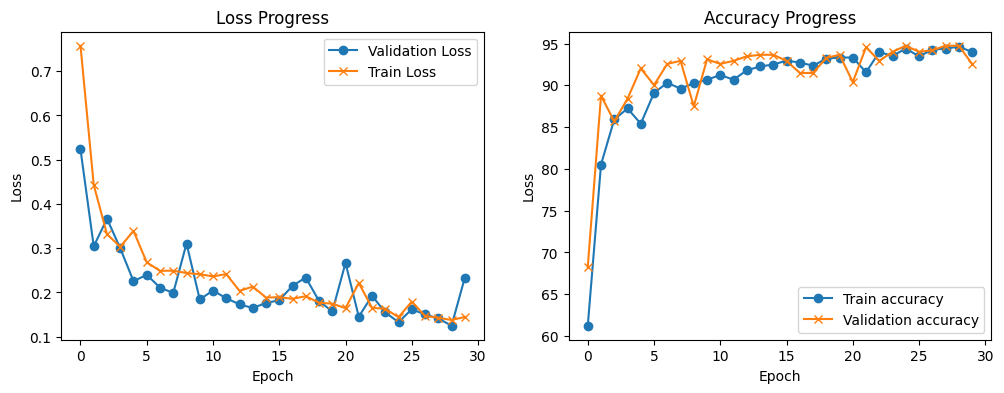

In [44]:
train_loop_plots(train_loss_list, validation_loss_list, train_accuracy_list, validation_accuracy_list)

Compared to the MLP model. You can see that the CNN model learns slower, the validation loss tracks the training loss relatively closely which means that the model is still learning with each new epoch. You can also see that the accuracy increases with each new epoch.

## Evaluating the CNN Model

Test data is used to evaluate the performance (accuracy) of our CNN model on unseen data. Note that accuracy is the default metric if one compiles the model with the accuracy metric.

In [45]:
with torch.no_grad():
    outputs = model_cnn(x_test_t.unsqueeze(1))
    y_test_pred_cnn = torch.where(outputs.squeeze(1) < 0.5, torch.tensor(0), torch.tensor(1))
print(f"Predicted label: {y_test_pred_cnn[0]}. Ground truth label: {y_test_t[0]}")

Predicted label: 1. Ground truth label: 1.0


Calculate correct and misclassifications

In [ ]:
test_misclass_cnn = (y_test_t != y_test_pred_cnn).sum().item()
test_goodclass_cnn = (y_test_t == y_test_pred_cnn).sum().item()
cnn_test_acc = (test_goodclass_cnn/len(y_test_pred_cnn))*100
print(f'Test, Correct classified examples: {test_goodclass_cnn}. Misclassified examples: {test_misclass_cnn}.')
print(f'Test, prediction accuracy: {cnn_test_acc:.2f}%')

Test, Correct classified examples: 551. Misclassified examples: 73.
Test, prediction accuracy: 79.01%


Display the confusion matrix. The sum of the elements in the main diagonal should be the same as the correct classifications we got above. The sum of the elements on the off-diagonal should be the same as the misclassifications above.  

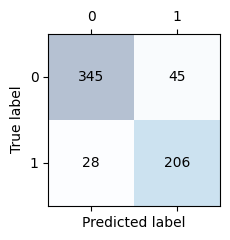

In [47]:
conf_matrix_cnn = confusion_matrix(y_test_t.cpu(), y_test_pred_cnn.cpu())
confusion_matrix_plot(conf_matrix_cnn)

Compute F1, precision and recall

In [48]:
f1_cnn = f1_score(y_test_t.cpu(), y_test_pred_cnn.cpu())
precision_cnn = precision_score(y_test_t.cpu(), y_test_pred_cnn.cpu())
recall_cnn = recall_score(y_test_t.cpu(), y_test_pred_cnn.cpu())

print(f'Precision score: {precision_cnn:.2f}\nRecall score:    {recall_cnn:0.2f}\nf1 score:        {f1_cnn:.2f}')

Precision score: 0.82
Recall score:    0.88
f1 score:        0.85


## Show what the NN model is learning after each layer

Pick one example from our training data to visualize our NN model's learning after each layer. Below we print the original image.

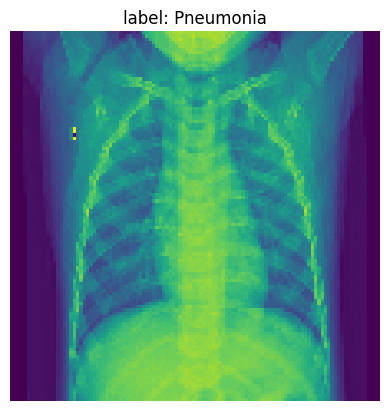

In [49]:
img_idx= 36
img_tensor = x_test_t[img_idx].unsqueeze(0).cpu()
  
plt.imshow(img_tensor[0]);
plt.title(f'label: {full_label(str(y_test_t[img_idx]))}')
plt.axis('off')
plt.show()

Track activations for one inference

In [50]:
activation_cnn = {}
def get_activation(name):
    def hook(model_cnn, input, output):
        activation_cnn[name] = output.detach()
    return hook

hook_list_cnn = []

hook_list_cnn.append(model_cnn.pool1.register_forward_hook(get_activation('pool1')))
hook_list_cnn.append(model_cnn.pool2.register_forward_hook(get_activation('pool2')))
hook_list_cnn.append(model_cnn.pool3.register_forward_hook(get_activation('pool3')))
hook_list_cnn.append(model_cnn.pool4.register_forward_hook(get_activation('pool4')))

# run 
with torch.no_grad():
    y_test_pred_idx = model_cnn(x_test_t[img_idx].unsqueeze(0))

Plot the `conv1` learned weights, next to the output feature map after `pool1`. We use the max and min amongst the tensor to plot the scale.

```{note}
Showing the learned weights for other layers is not as straightforward as there are multiple shapes involved. This is a good exercise for the reader.
```

Displaying learned weights for conv1 layer, shape: [32, 1, 3, 3], number of 2d learned kernels: 32



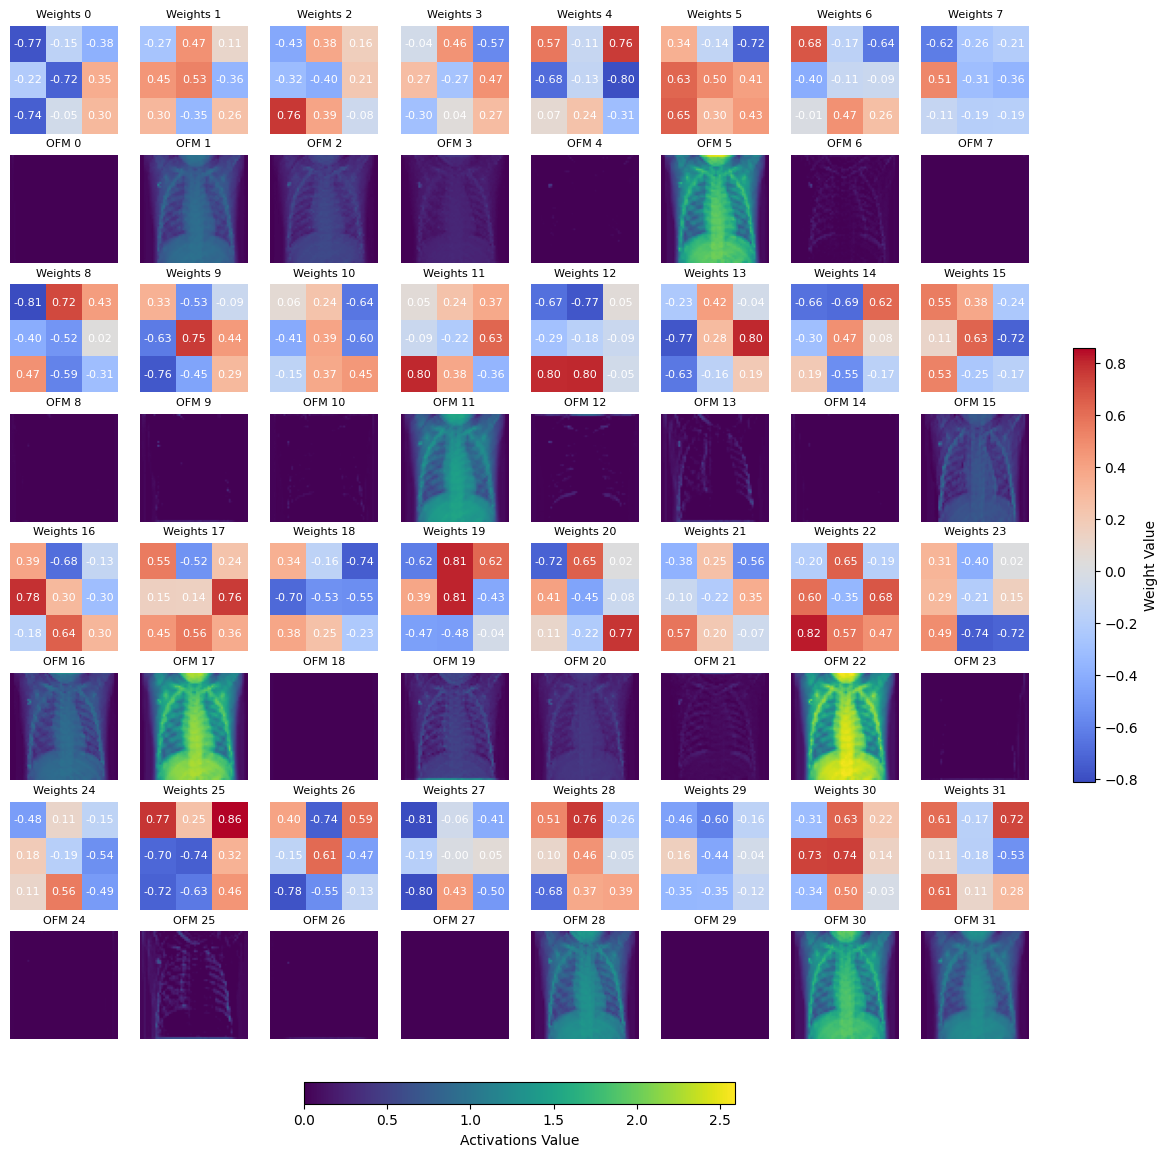

In [51]:
weight = model_cnn.conv1.weight
activation = activation_cnn['pool1']

nrows, ncols = (8*weight.shape[0]//32, 8)
fig, axs = plt.subplots(nrows, ncols, figsize=(14, 7 * nrows//4))
print(f'Displaying learned weights for conv1 layer, shape: {list(weight.shape)}, number of 2d learned kernels: {weight.shape[0]}\n')
max_val = torch.max(weight)
min_val = torch.min(weight)
for ch in range(weight.shape[0]):
    r, c = (ch//8)*2, ch%8
    kernel = weight[ch].squeeze(0).cpu().detach().numpy()
    im = axs[r, c].imshow(kernel, cmap='coolwarm', vmin=min_val, vmax=max_val)
    for (i, j), val in np.ndenumerate(kernel):
        axs[r, c].text(j, i, f'{val:.2f}', ha='center', va='center', color='white', fontdict={'size': 8})
    axs[r, c].set_title(f'Weights {str(ch)}', fontsize = 8)
    axs[r, c].axis('off')

max_val = torch.max(activation)
for ch in range(activation.shape[0]):
    r, c = (ch//8)*2+1, ch%8
    act_norm = activation[ch].cpu() / torch.max(activation[ch].cpu())
    im1 = axs[r, c].imshow(activation[ch].cpu(), cmap='viridis', vmin=0, vmax=max_val)
    axs[r, c].set_title(f'OFM {str(ch)}', fontsize = 8)
    axs[r, c].axis('off')
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Weight Value')
cbar1 = fig.colorbar(im1, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04)
cbar1.set_label('Activations Value')
plt.show()

We can also plot the activations (output feature map) after the pool layer, for pool2 and pool3.

```{tip}
You can also plot the activations for `pool1` and `pool4`, to do this remove the code that skips these layers from the cell below.
```

```python
if k in ['pool1', 'pool4']:
    continue
```

Displaying layer: pool2, shape: [64, 28, 28], number of output feature maps (OFM): 64



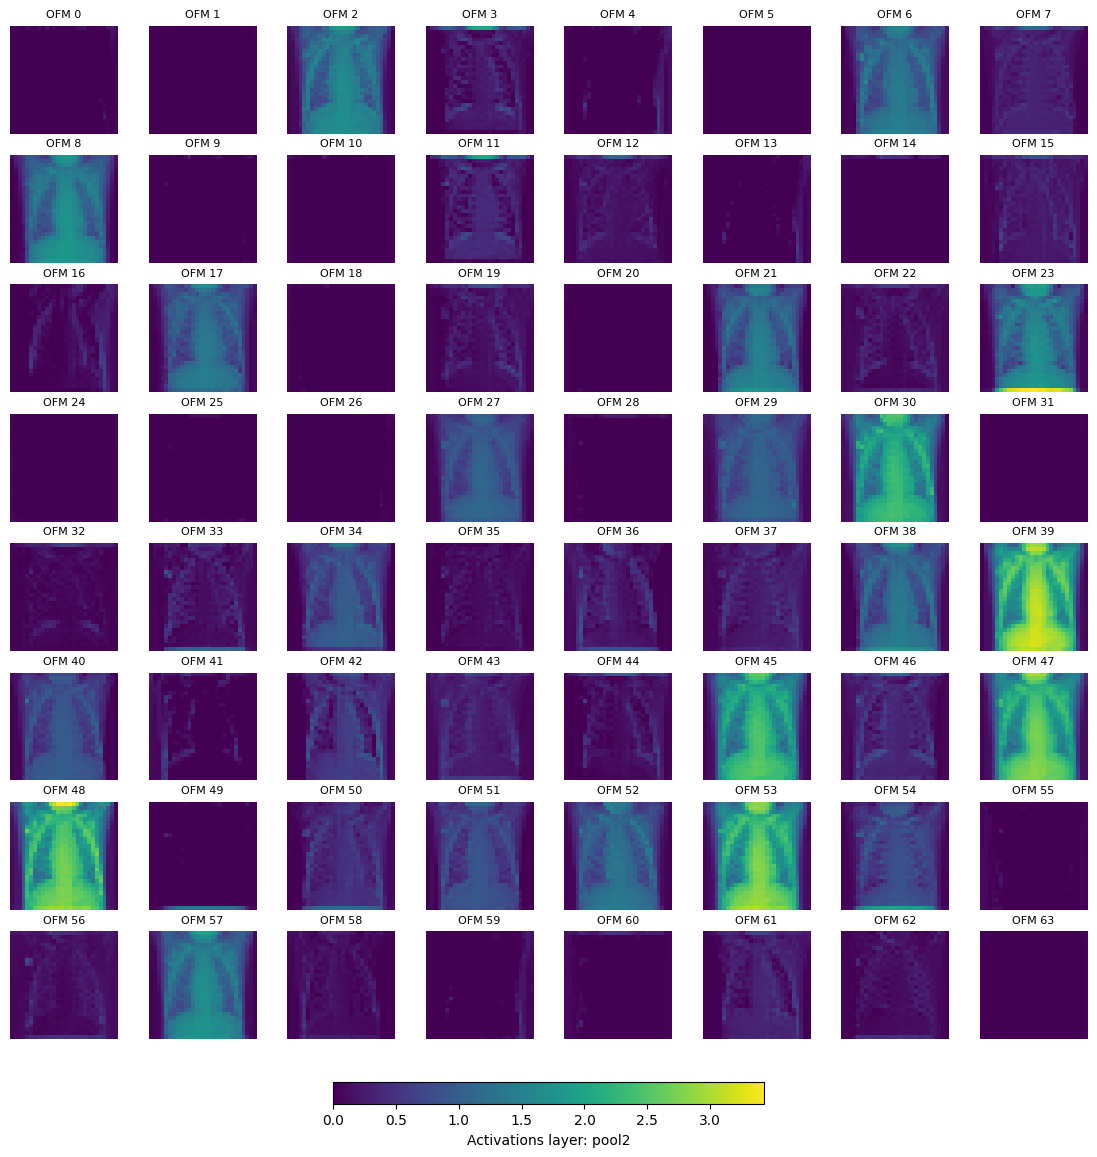

Displaying layer: pool3, shape: [128, 14, 14], number of output feature maps (OFM): 128



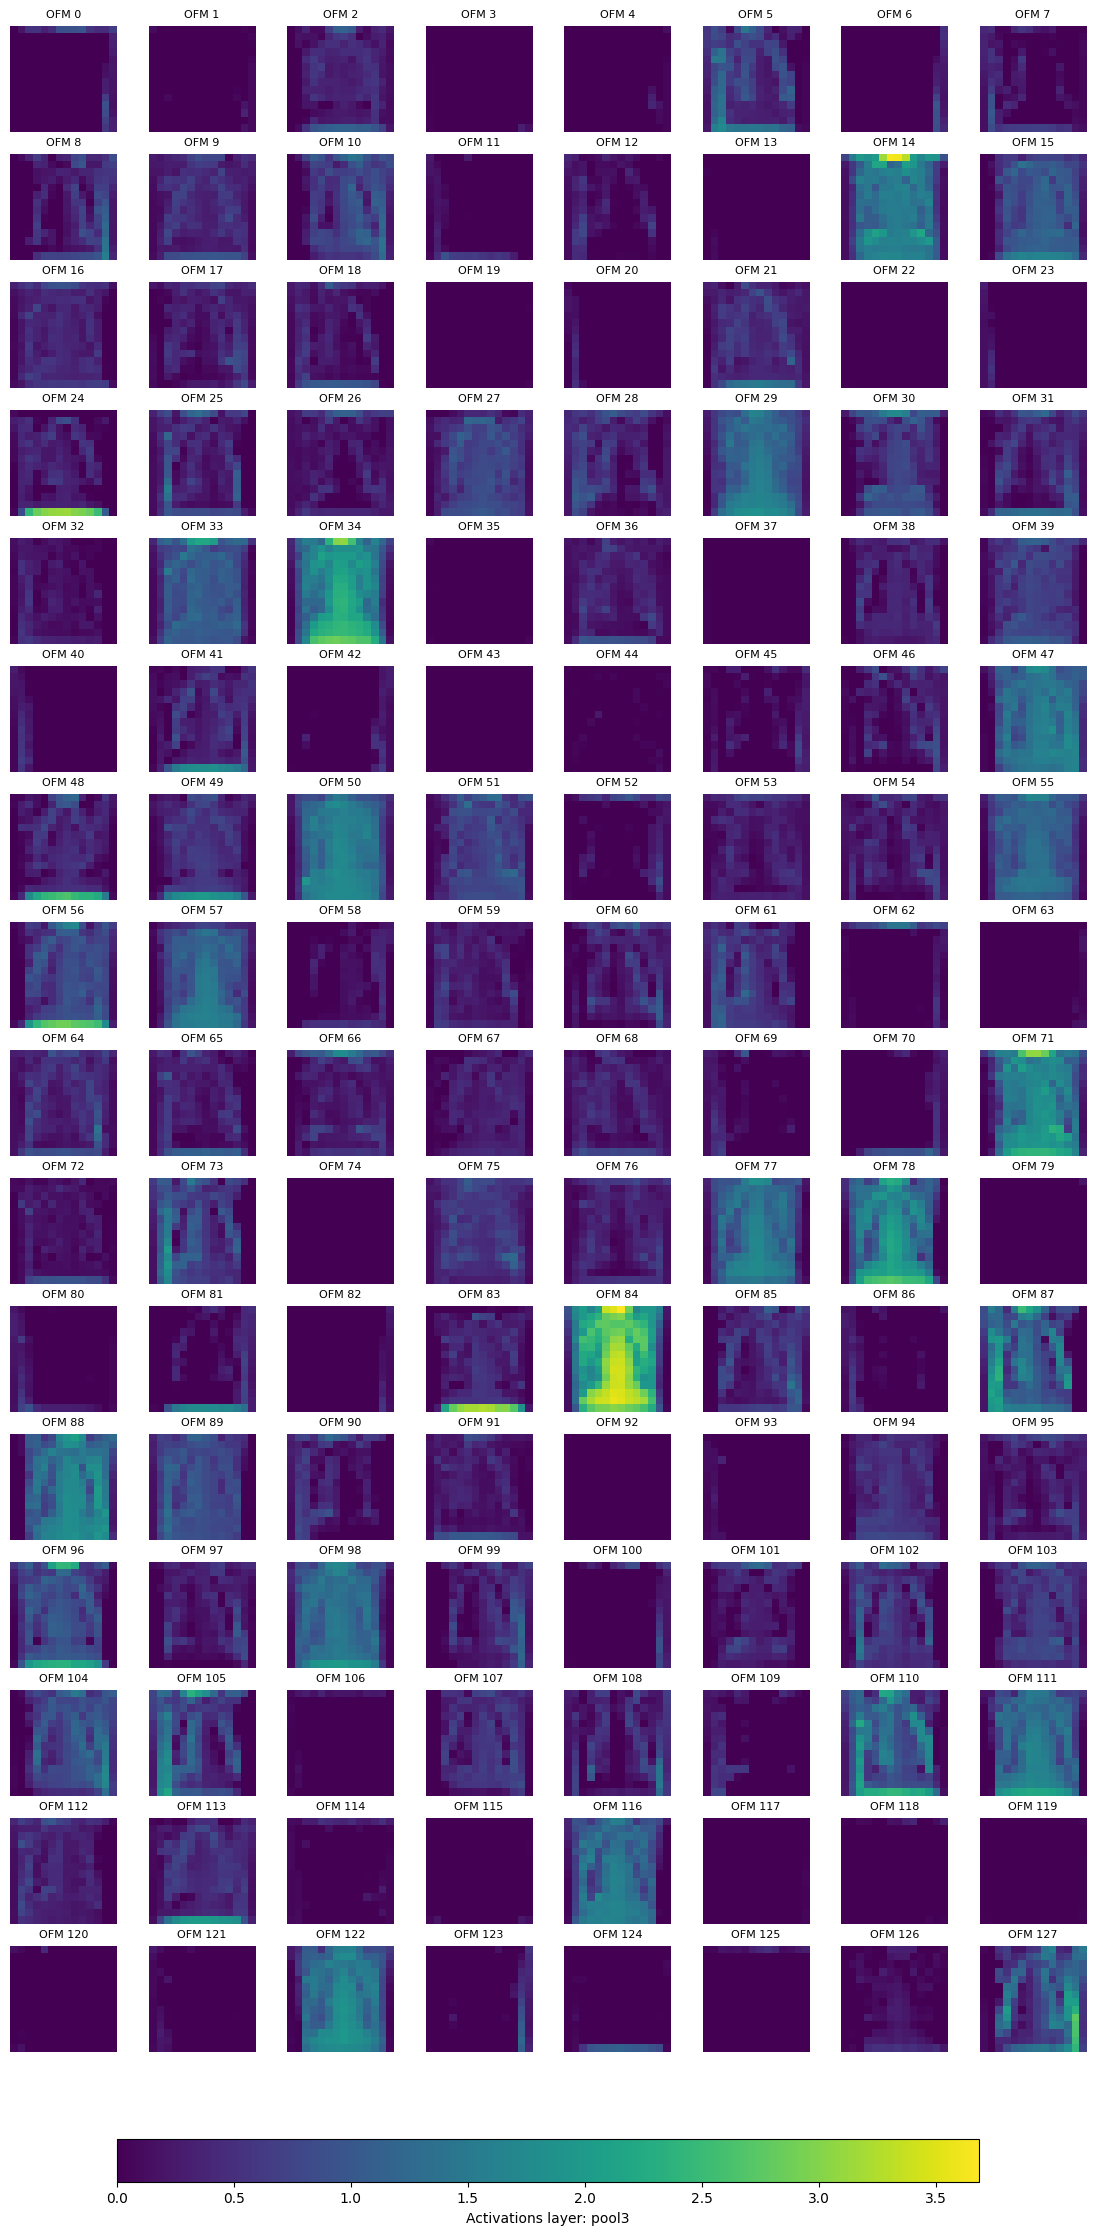

In [52]:
for k, activation in activation_cnn.items():
    if k in ['pool1', 'pool4']:
        continue
    nrows, ncols = (4*activation.shape[0]//32, 8)
    fig, axs = plt.subplots(nrows, ncols, figsize=(14, 7 * nrows//4))
    print(f'Displaying layer: {k}, shape: {list(activation.shape)}, number of output feature maps (OFM): {activation.shape[0]}\n')
    max_val = torch.max(activation)
    for ch in range(activation.shape[0]):
        r, c = (ch//8), ch%8
        im = axs[r, c].imshow(activation[ch].cpu().numpy(), cmap='viridis', vmin=0, vmax=max_val)
        axs[r, c].set_title(f'OFM {str(ch)}', fontsize = 8)
        axs[r, c].axis('off')
    cbar = fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04)
    cbar.set_label(f'Activations layer: {k}')
    plt.show()

Finally, we can remove the hooks

In [53]:
for hook in hook_list_cnn:
    hook.remove()

## Using Explainability Frameworks to Understand the CNN Model

## Pytorch Grad Cam

[`pytorch-grad-cam`](https://github.com/jacobgil/pytorch-grad-cam) is a Python package for advanced AI explainability for PyTorch. We will use it to understand a bit better at what parts of the image the model is looking when making a classification.

Let's tart with samples that are labeled as normal in our test set.

In [86]:
from pytorch_grad_cam import GradCAM, HiResCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layers = [model_cnn.conv4]
input_tensor = x_test_t[0:32].unsqueeze(1)
targets = None

with HiResCAM(model=model_cnn, target_layers=target_layers) as cam:
    cam.batch_size = 1
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    img = x_val_t[350].cpu().numpy()
    visualization = show_cam_on_image(np.stack((img, img, img), axis=-1), grayscale_cam, use_rgb=True)

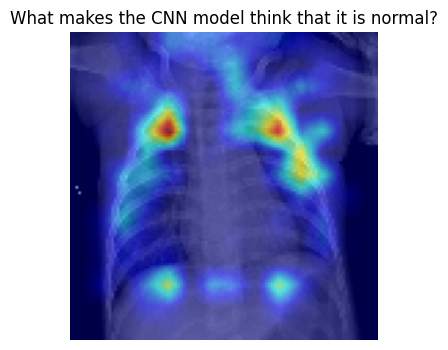

In [87]:
plt.figure(figsize=(8,4))
plt.imshow(visualization)
plt.title(f"What makes the CNN model think that it is normal?")
plt.axis('off')
plt.show()

Now, let's get some understanding of what the model looks when it is pneumonia

In [56]:
target_layers = [model_cnn.conv4]
input_tensor = x_test_t[200:232].unsqueeze(1)
targets = None

with HiResCAM(model=model_cnn, target_layers=target_layers) as cam:
    cam.batch_size = 1
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    img = x_val_t[251].cpu().numpy()
    visualization = show_cam_on_image(np.stack((img, img, img), axis=-1), grayscale_cam, use_rgb=True)

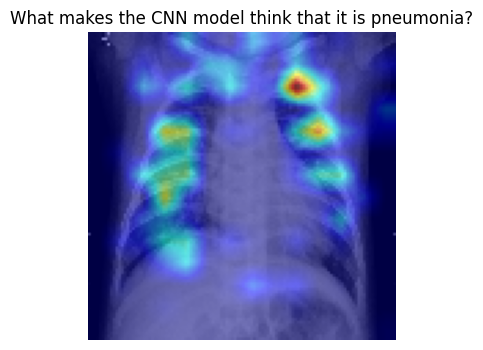

In [57]:
plt.figure(figsize=(8,4))
plt.imshow(visualization)
plt.title(f"What makes the CNN model think that it is pneumonia?")
plt.axis('off')
plt.show()

```{tip}
`pytorch_grad_cam` has multiple [methods for explainability](https://github.com/jacobgil/pytorch-grad-cam/blob/master/README.md#advanced-ai-explainability-for-pytorch), try with different ones and see what is the result. For instance, `GradCAM` or `GradCAMPlusPlus`.
```

In [58]:
y_val_t[280:288]

tensor([0., 0., 0., 0., 1., 1., 1., 1.], device='cuda:0')

### SHapley Additive exPlanations (SHAP)

[SHAP](https://shap.readthedocs.io/en/latest/) is a game theoretic approach to explain the output of any machine learning model.

In [59]:
import shap

background = torch.cat((x_val_t[8:40], x_val_t[400:432]), dim=0).unsqueeze(1)
test_images = x_val_t[280:288].unsqueeze(1)

e = shap.GradientExplainer(model_cnn, background)
shap_values = e.shap_values(test_images)

In [60]:
shap_numpy = list(np.transpose(shap_values, (4, 0, 2, 3, 1)))
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)

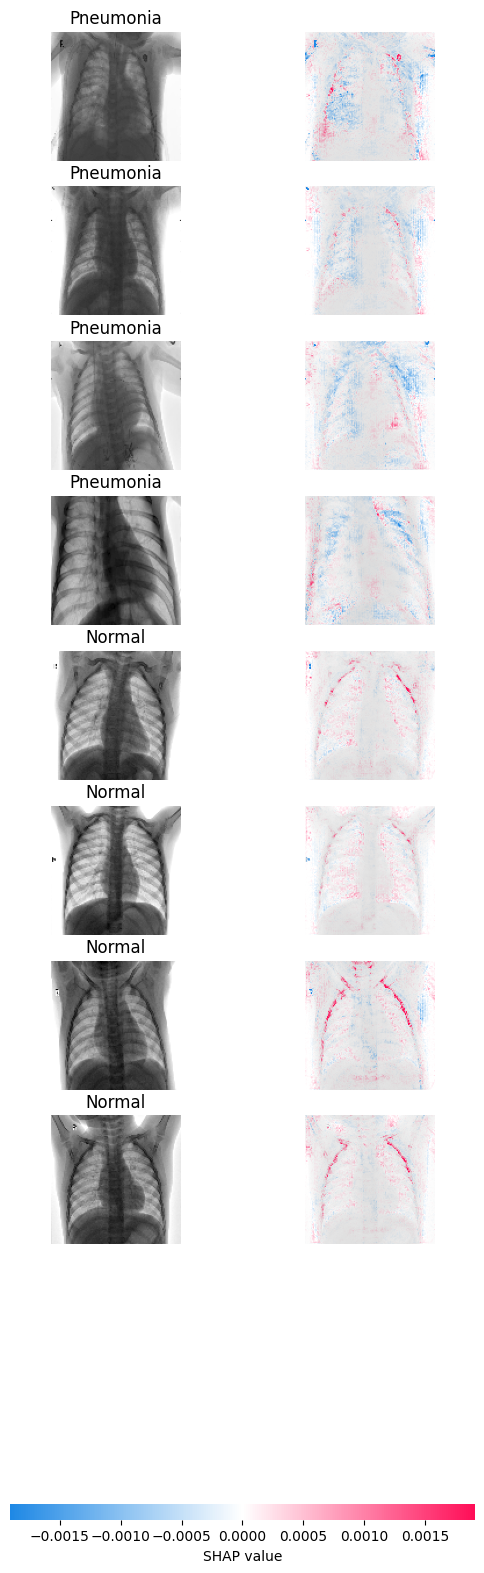

In [61]:
shap.image_plot(shap_numpy, -test_numpy, true_labels=['Pneumonia', 'Pneumonia', 'Pneumonia','Pneumonia', 'Normal', 'Normal', 'Normal', 'Normal'])

What you see in the left is the sample that the model evaluates, on the right you can see the gradients. The more blue you see, the more the gradients are pushing the model to classify the sample as pneumonia. On the contrary, the more red, the model is pushed to classify the sample as normal. The areas where you see these colors are the ones influencing the classification the most.

### CNN Model Hyper parameter tuning

```{tip}
As models take a long time to run because of larger image dataset the following experiments on the hyperparameter tuning can be performed as shown in the table below
```


|Model|  kernel size |  strides | pool size  |  learning rate | optimizer  | brightness_range   |  zoom_range      | horizontal_flip  | Training accuracy | Validation accuracy | Test accuracy |
|:-:  |:-:           |:-:       |:-:         |:-:             |:-:         |:-:                 |:-:               |:-:               |:-:                |:-:                  |:-:            |
|0    | 3,3          | 1,1      | 2,2        | 0.001          | Adam       | None               | 0.2              | True             | ?                 | ?                   | ?             |
|1    | 3,3          | 1,1      | 2,2        | 0.01           | Adam       | None               | 0.2              | True             | ?                 | ?                   | ?             |
|2    | 3,3          | 2,2      | 2,2        | 0.001          | Adam       | None               | 0.2              | True             | ?                 | ?                   | ?             |
|3    | 5,5          | 1,1      | 2,2        | 0.001          | Adam       | None               | 0.2              | True             | ?                 | ?                   | ?             |
|4    | 3,3          | 1,1      | 3,3        | 0.001          | Adam       | None               | 0.2              | True             | ?                 | ?                   | ?             |
|5    | 3,3          | 1,1      | 4,4        | 0.001          | Adam       | None               | 0.2              | True             | ?                 | ?                   | ?             |
|6    | 3,3          | 1,1      | 2,2        | 0.001          | Adam       | (0.1,0.3)          | 0.2              | True             | ?                 | ?                   | ?             |
|7    | 3,3          | 1,1      | 2,2        | 0.001          | Adam       | None               | 0.4              | True             | ?                 | ?                   | ?             |
|8    | 3,3          | 1,1      | 2,2        | 0.001          | Adam       | None               | 0.2              | False            | ?                 | ?                   | ?             |
|9    | 3,3          | 1,1      | 2,2        | 0.001          | SGD        | None               | 0.2              | True             | ?                 | ?                   | ?             |

## Data-efficient Image Transformers (DeIT) Model

Suggested hardware 🛠️: **AMD Instinct™ Accelerators**. At least 48 GB of memory is needed to fine-tune the model

### Define the DeIT Model

We are going to import the [deit-tiny-distilled-patch16-224](https://huggingface.co/facebook/deit-tiny-distilled-patch16-224) directly from HuggingFace. We're using the `DeiTForImageClassification` class from [HuggingFace's transformers](https://huggingface.co/docs/transformers/en/index) that allows to specify the number of labels, as we're doing binary classification we set `num_labels=1`.

See a diagram of the DeIT architecture below:

```{figure} images/deit_architecture.png
:scale: 40 %
:alt: deit architecture

Data-efficient Image Transformers architecture. Attribution: Training data-efficient image transformers & distillation through attention
```

```{seealso}
[Training data-efficient image transformers & distillation through attention](https://arxiv.org/pdf/2012.12877)

[Hugging Face Distilled Data-efficient Image Transformer (tiny-sized model)](https://huggingface.co/facebook/deit-tiny-patch16-224)
```

We also use `DeiTImageProcessor` in order to prepare the input images to the model. As our dataset is fully normalized we set `do_normalize=False`.

In [62]:
from transformers import DeiTForImageClassification, DeiTImageProcessor
from torch import nn

# Load the pretrained DeiT model
model_id = 'facebook/deit-tiny-distilled-patch16-224'
model_deit = DeiTForImageClassification.from_pretrained(model_id, num_labels=1)
image_processor = DeiTImageProcessor.from_pretrained(model_id, do_rescale=False, do_normalize=False)

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
model_deit

DeiTForImageClassification(
  (deit): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTSdpaAttention(
            (attention): DeiTSdpaSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): L

Because `DeIT` expects the input image in the form of an RGB image with a shape of 224, 224. Instead of recreating the dataloaders, we will use some transformations to bring the dataset to this format.

`transform_to_rgb` resizes the image to the correct dimension and transforms it into RGB. `transform_to_tensor` just transforms an image to tensor.

In [63]:
transform_to_rgb = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_to_tensor = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

Due to the way the `DeiT` model expects the input images and returns the result, we need to rewrite the training loops. For the most part is similar to the one used for the MLP and CNN model. 

The two main differences are how we pass the input images and how we process the output to the model. Because we need to use [`DeiTImageProcessor`](https://huggingface.co/docs/transformers/v4.46.0/en/model_doc/deit#transformers.DeiTImageProcessor) to process the input to the mode, we need to pass the `pixel_values` to the model. Also, to compute the loss, we need to get the `.logits` of the model.

In [67]:
def deit_train_loop(model, loss_fn, optimizer, device, epochs=30, print_every=5):
    validation_loss_list, train_loss_list, val_accuracy_list, train_accuracy_list = [], [], [], []
    
    model.to(device) # move the model to GPU if available
    
    for epoch in range(epochs):
        training_loss, correct, total = 0, 0, 0
        model.train()  # Set the model to training mode
        for inputs, targets in train_loader:
            optimizer.zero_grad()

            transformed_batch = torch.stack([transform_to_rgb(image) for image in inputs]).squeeze(1)  # Grayscale to RGB
            transformed_batch = torch.stack([transform(image) for image in transformed_batch])  # Apply data augmentation
            inputs_batched = image_processor(images=transformed_batch, return_tensors="pt").to(device)['pixel_values']
            labels = targets.to(device).float()
           
            outputs = model_deit(inputs_batched).logits.squeeze()

            loss = loss_fn(outputs, targets)
            training_loss += loss.item()
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
    
            # track accuracy
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += targets.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    
        training_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
    
        # Validation
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # No need to track gradients
            val_loss, correct, total = 0, 0, 0
            for inputs, targets in val_loader:

                transformed_batch = torch.stack([transform_to_rgb(image) for image in inputs]).squeeze(1)  # Grayscale to RGB
                transformed_batch = torch.stack([transform_to_tensor(image) for image in transformed_batch])
                inputs_batched = image_processor(images=transformed_batch, return_tensors="pt").to(device)['pixel_values']
                labels = targets.to(device).float()

                outputs = model(inputs_batched).logits
                loss = loss_fn(outputs.squeeze(), labels)
                val_loss += loss.item()
                
                # track accuracy
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                total += targets.size(0)
                correct += (predicted.squeeze() == labels).sum().item()
            val_loss /= len(val_loader)
            val_accuracy = 100 * correct / total
    
        if epoch % print_every == 0 or epoch == epochs - 1:
            print(f'Epoch {epoch+1:4d}/{epochs}, training loss: {training_loss:3.12f}, '
                  f'validation loss: {val_loss:3.12f} training accuracy: {train_accuracy:.2f}, validation accuracy {val_accuracy:.2f}')
        validation_loss_list.append(val_loss)
        train_loss_list.append(training_loss)
        train_accuracy_list.append(train_accuracy)
        val_accuracy_list.append(val_accuracy)

    return model, train_loss_list, validation_loss_list, train_accuracy_list, val_accuracy_list

For the training we use `BCEWithLogitsLoss` as loss function and `Adam` as the optimizer. We run the training loop for 30 epochs.

In [68]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_deit.parameters(), lr=1e-4)

t_start = time.time()
model_deit, train_loss_list, validation_loss_list, train_accuracy_list, validation_accuracy_list = deit_train_loop(model_deit, loss_fn, optimizer, device, epochs=30, print_every=5)
ttrain_deit = time.time() - t_start
print(f'It took {ttrain_deit:.2f}s to train the DeiT model')

Epoch    1/30, training loss: 0.206382036497, validation loss: 0.183160780412 training accuracy: 91.47, validation accuracy 94.38
Epoch    6/30, training loss: 0.116164267200, validation loss: 0.252527772268 training accuracy: 94.97, validation accuracy 92.39
Epoch   11/30, training loss: 0.106113039341, validation loss: 0.180631733480 training accuracy: 96.46, validation accuracy 94.38
Epoch   16/30, training loss: 0.108383984113, validation loss: 0.104096560636 training accuracy: 96.09, validation accuracy 96.74
Epoch   21/30, training loss: 0.166550159033, validation loss: 0.216299622869 training accuracy: 93.29, validation accuracy 93.12
Epoch   26/30, training loss: 0.081173773420, validation loss: 0.148144995690 training accuracy: 97.20, validation accuracy 95.83
Epoch   30/30, training loss: 0.068769036145, validation loss: 0.207705604768 training accuracy: 97.30, validation accuracy 94.93
It took 846.40s to train the DeiT model


Plot the training progress

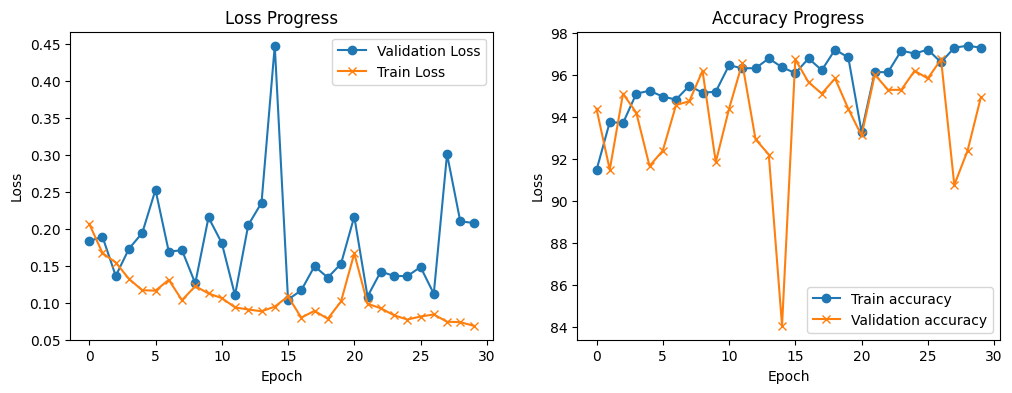

In [69]:
train_loop_plots(train_loss_list, validation_loss_list, train_accuracy_list, validation_accuracy_list)

We can see that with each training epoch the model achieves lower training loss, however the validation loss is varies a lot. The training accuracy also increases with the number of epochs and the validation accuracy varies a lot, but it is over 90%.

### DeIT Model Evaluation

Let compute the accuracy for the DeIT model

In [70]:
with torch.no_grad():
    test_transformed = torch.stack([transform_to_rgb(image) for image in x_test_t]).squeeze(1)
    test_transformed = torch.stack([transform_to_tensor(image) for image in test_transformed])
    inputs_batched = image_processor(images=test_transformed, return_tensors="pt").to(device)
    outputs = model_deit(**inputs_batched).logits.squeeze()
    y_test_pred_deit = (torch.sigmoid(outputs) > 0.5).float()

# print the predictions for the first example in test data
print(f"Predicted label: {y_test_pred_deit[0]}. Ground truth label: {y_test_t[0]}")

Predicted label: 1.0. Ground truth label: 1.0


In [71]:
test_misclass_deit = (y_test_t != y_test_pred_deit).sum().item()
test_goodclass_deit = (y_test_t == y_test_pred_deit).sum().item()
deit_test_acc = (test_goodclass_deit/len(y_test_pred_deit))*100
print(f'Test, correct classified examples: {test_goodclass_deit}. Misclassified examples: {test_misclass_deit}. ')
print(f'Test, prediction accuracy: {deit_test_acc:.2f}%')

Test, correct classified examples: 557. Misclassified examples: 67. 
Test, prediction accuracy: 89.26%


Let's display the confusion matrix

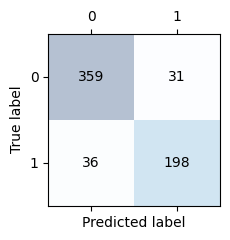

In [72]:
conf_matrix_deit = confusion_matrix(y_test_t.cpu(), y_test_pred_deit.cpu())

confusion_matrix_plot(conf_matrix_deit)

Compute model statistics

In [73]:
f1_deit = f1_score(y_test_t.cpu(), y_test_pred_deit.cpu())
precision_deit = precision_score(y_test_t.cpu(), y_test_pred_deit.cpu())
recall_deit = recall_score(y_test_t.cpu(), y_test_pred_deit.cpu())

print(f'Precision score: {precision_deit:.2f}\nRecall score:    {recall_deit:0.2f}\nf1 score:        {f1_deit:.2f}')

Precision score: 0.86
Recall score:    0.85
f1 score:        0.86


## Models Summary

In this section we will compare the three different models we explored in this notebook. First, let's start by evaluating the MLP model layers and overall size.

In [74]:
from torchinfo import summary
mlp_model_stat = summary(model_fc, input_size=(1, 112, 112), col_names=["input_size", "output_size", "num_params", "mult_adds", "trainable"])
mlp_model_stat

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
MLPPneumonia                             [1, 112, 112]             [1, 1]                    --                        --                        True
├─Flatten: 1-1                           [1, 112, 112]             [1, 12544]                --                        --                        --
├─Linear: 1-2                            [1, 12544]                [1, 12544]                157,364,480               157,364,480               True
├─ReLU: 1-3                              [1, 12544]                [1, 12544]                --                        --                        --
├─Linear: 1-4                            [1, 12544]                [1, 3136]                 39,341,120                39,341,120                True
├─ReLU: 1-5                              [1, 3136]                 [1, 3136]                 --    

Now, let's check the CNN model

In [75]:
cnn_model_stats = summary(model_cnn, input_size=(1, 112, 112), col_names=["input_size", "output_size", "num_params", "mult_adds", "trainable"])
cnn_model_stats

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
CNNPneumonia                             [1, 112, 112]             [1, 1]                    --                        --                        True
├─Conv2d: 1-1                            [1, 112, 112]             [32, 112, 112]            320                       1,146,880                 True
├─MaxPool2d: 1-2                         [32, 112, 112]            [32, 56, 56]              --                        --                        --
├─Conv2d: 1-3                            [32, 56, 56]              [64, 56, 56]              18,496                    66,289,664                True
├─MaxPool2d: 1-4                         [64, 56, 56]              [64, 28, 28]              --                        --                        --
├─Conv2d: 1-5                            [64, 28, 28]              [128, 28, 28]             73,856

Finally, plot the summary of the DeIT model

In [76]:
deit_model_stats = summary(model_deit, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "mult_adds", "trainable"])
deit_model_stats

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
DeiTForImageClassification                                   [1, 3, 224, 224]          [1, 1]                    --                        --                        True
├─DeiTModel: 1-1                                             [1, 3, 224, 224]          [1, 198, 192]             --                        --                        True
│    └─DeiTEmbeddings: 2-1                                   [1, 3, 224, 224]          [1, 198, 192]             38,400                    --                        True
│    │    └─DeiTPatchEmbeddings: 3-1                         [1, 3, 224, 224]          [1, 196, 192]             147,648                   28,939,008                True
│    │    └─Dropout: 3-2                                     [1, 198, 192]             [1, 198, 192]             --                        --    

In [79]:
from IPython.display import Markdown

summary_md = f'''
| Model | Number of Parameters               | Training Time (s) | Test Accuracy (%)   | F1            | Precision            | Recall            |
|-------|------------------------------------|-------------------|---------------------|---------------|----------------------|-------------------|
| MLP   | {mlp_model_stat.total_params:,}    | {ttrain_fc:.2f}   | {mlp_test_acc:.2f}  | {f1_mlp:.3f}  | {precision_mlp:.3f}  | {recall_mlp:.3f}  |
| CNN   | {cnn_model_stats.total_params:,}   | {ttrain_cnn:.2f}  | {cnn_test_acc:.2f}  | {f1_cnn:.3f}  | {precision_cnn:.3f}  | {recall_cnn:.3f}  |
| DeIT  | {deit_model_stats.total_params:,}  | {ttrain_deit:.2f} | {deit_test_acc:.2f} | {f1_deit:.3f} | {precision_deit:.3f} | {recall_deit:.3f} |
'''

Markdown(summary_md)


| Model | Number of Parameters | Training Time (s) | Test Accuracy (%) | F1 | Precision | Recall | 
|-------|----------------------|---------------|---------------|----|-----------|--------|
| MLP   | 199,165,793    |  76.70  | 79.01   | 0.772  | 0.651  | 0.949 |
| CNN   | 3,599,617  | 32.32  | 79.01   | 0.849  | 0.821  | 0.880 |
| DeIT  | 5,524,993 | 846.40 |  89.26 | 0.855 | 0.865 | 0.846 |


## Conclusions

In this notebook we explored three different models to classify pneumonia based on x-rays. The three models perform relatively well when measured against the test dataset. However, the number of parameters (which directly relates to the amount of compute) and the training time vary significantly. The CNN with ~88% accuracy and the less number of parameters seems to be the best alternative.

## References

* Gender Rib Cage - https://pubmed.ncbi.nlm.nih.gov/16476656/
* Misdiagnosis - https://pubmed.ncbi.nlm.nih.gov/32723999/

----------
Copyright (C) 2025 Advanced Micro Devices, Inc. All rights reserved. Portions of this file consist of AI-generated content.

SPDX-License-Identifier: MIT